In [1]:
%matplotlib_svg
import numpy as np
import pylab as pl
import cv2
from cv2 import cv
from numpy import fft

## 形状与结构分析

### 轮廓检测

> **SOURCE**

> `scpy2.opencv.findcontours_demo`：轮廓检测演示程序

In [2]:
#%hide
%exec_python -m scpy2.opencv.findcontours_demo

In [3]:
img_coin = cv2.imread("coins.png", cv2.IMREAD_COLOR)
img_coin_gray = cv2.cvtColor(img_coin, cv2.COLOR_BGR2GRAY)
img_coin_blur = cv2.GaussianBlur(img_coin_gray, (0, 0), 1.5, 1.5)
img_coin_binary = cv2.Canny(img_coin_blur.copy(), 60, 60)
img_coin_binary = cv2.morphologyEx(img_coin_binary, cv2.MORPH_CLOSE, 
                                   np.ones((3, 3), "uint8"))

In [4]:
for approx in ["NONE", "SIMPLE", "TC89_KCOS", "TC89_L1"]:
    approx_flag = getattr(cv2, "CHAIN_APPROX_{}".format(approx))
    coin_contours, hierarchy = cv2.findContours(img_coin_binary.copy(), 
                           cv2.RETR_EXTERNAL, approx_flag)
    print("{}: {}  ".format(approx, sum(contour.shape[0] for contour in coin_contours)), end=' ')

NONE: 3179   SIMPLE: 1579   TC89_KCOS: 849   TC89_L1: 802  


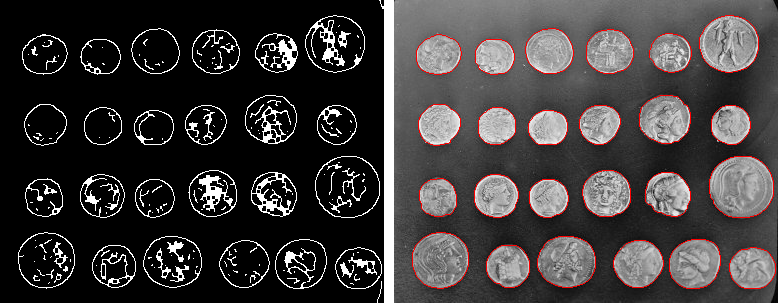

In [5]:
#%fig=显示所有圆度在0.8到1.2之间的轮廓
def circularity(contour):
    perimeter = cv2.arcLength(contour, True)
    area = cv2.contourArea(contour) + 1e-6
    return perimeter * perimeter / (4 * np.pi * area)

coin_contours = [contour for contour in coin_contours 
                 if 0.8 < circularity(contour) < 1.2]
cv2.drawContours(img_coin, coin_contours, -1, (255, 0, 0))
#%hide
%array_image img_coin_binary; img_coin

In [12]:
img_pattern = cv2.imread("nested_patterns.png")
img_pattern_gray = cv2.cvtColor(img_pattern, cv2.COLOR_BGR2GRAY)
_, img_pattern_binary = cv2.threshold(img_pattern_gray, 100, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(img_pattern_binary.copy(),
        cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
hierarchy.shape = -1, 4

In [13]:
root_index = [i for i in range(len(hierarchy)) if hierarchy[i, 3] < 0]
root_index

[0, 7, 19]

In [14]:
def get_children(hierarchy, index):
    first_child = hierarchy.item(index, 2)
    if first_child >= 0:
        yield first_child
        brother = hierarchy.item(first_child, 0)
        while brother >= 0:
            yield brother
            brother = hierarchy.item(brother, 0)
            
def get_descendant(hierarchy, index, level=1):
    for child in get_children(hierarchy, index):
        yield level, child
        for item in get_descendant(hierarchy, child, level + 1):
            yield item
            
print((list(get_descendant(hierarchy, 0))))

[(1, 1), (2, 2), (3, 3), (2, 4), (3, 5), (3, 6)]


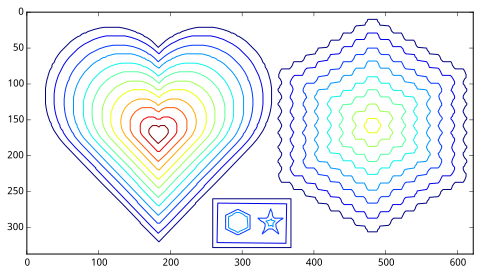

In [15]:
#%figonly=显示轮廓的层次结构
root_index = [i for i in range(len(hierarchy)) if hierarchy[i, 3] < 0]

lines = []
levels = []

for index in root_index:
    items = list(zip(*get_descendant(hierarchy, index)))
    if items:
        children_level, children_index = items
        lines.extend([contours[i] for i in children_index])
        levels.extend(children_level)
    lines.append(contours[index])
    levels.append(0)
    
lines = [line[:, 0, :] for line in lines]
    
from matplotlib.collections import LineCollection, PolyCollection
fig, ax = pl.subplots(figsize=(8, 8))
ax.set_aspect("equal")
polys = PolyCollection(lines, array=np.array(levels), facecolors="none")
ax.add_collection(polys)
ax.set_xlim(0, img_pattern.shape[1])
ax.set_ylim(img_pattern.shape[0], 0);

### 轮廓匹配

In [2]:
img_patterns = cv2.imread("patterns.png", cv2.IMREAD_GRAYSCALE)
patterns, _ = cv2.findContours(img_patterns, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_targets = cv2.imread("targets.png", cv2.IMREAD_GRAYSCALE)
targets, _ = cv2.findContours(img_targets, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

patterns = [pattern - np.min(pattern, 0, keepdims=True) for pattern in patterns] #❶
targets = [target - np.min(target, 0, keepdims=True) for target in targets]

patterns_simple = [cv2.approxPolyDP(pattern, 5, True) for pattern in patterns] #❷
targets_simple = [cv2.approxPolyDP(target, 8, True) for target in targets]

In [3]:
for method in [1, 2, 3]:
    method_str = "CV_CONTOURS_MATCH_I{}".format(method)
    method = getattr(cv, method_str)
    scores = [cv2.matchShapes(targets_simple[0], patterns_simple[pidx], method, 0)
                  for pidx in range(5)]
    print((method_str, ", ".join("{: 8.4f}".format(score) for score in scores)))

CV_CONTOURS_MATCH_I1  11.3737,   0.3456,   0.0289,   1.0495,   0.0020
CV_CONTOURS_MATCH_I2   4.8051,   2.2220,   0.0179,   0.3624,   0.0013
CV_CONTOURS_MATCH_I3   0.9164,   0.4778,   0.0225,   0.4552,   0.0016


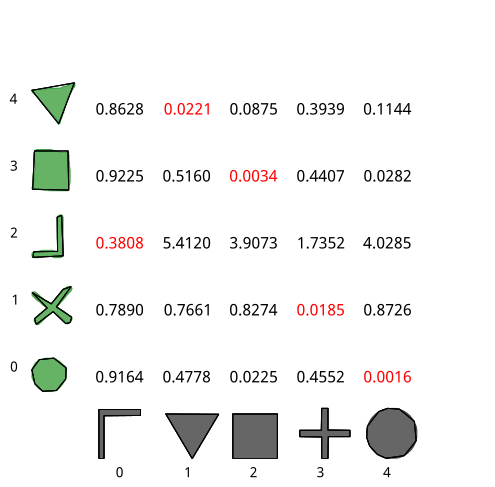

In [4]:
#%figonly=使用`matchShapes()`比较由`approxPolyDP()`近似之后的轮廓
fig, ax = pl.subplots(figsize=(8, 8))
ax.set_aspect("equal")

width = 180
for tidx, (target, target_simple) in enumerate(zip(targets, targets_simple)): 
    scores = []
    texts = []
    for pidx, (pattern, pattern_simple) in enumerate(zip(patterns, patterns_simple)):
        index = np.s_[:, 0, :]
        pattern2 = pattern[index]
        target2 = target[index]
        pattern_simple2 = pattern_simple[index]
        target_simple2 = target_simple[index]
        
        x0 = pidx * width + width
        y0 = tidx * width + width
        
        if tidx == 0:
            pattern_poly = pl.Polygon(pattern2 + [x0, 0], color="black", alpha=0.6)
            ax.add_patch(pattern_poly)
            text = ax.text(x0 + width * 0.3, -50, str(pidx), fontsize=14, ha="center")
        if pidx == 0:
            target_poly = pl.Polygon(target2 + [0, y0], color="green", alpha=0.6)
            ax.add_patch(target_poly)
            text = ax.text(-50, y0 + width * 0.3, str(tidx), fontsize=14, ha="center")

        pattern_simple_poly = pl.Polygon(pattern_simple2 + [x0, 0], facecolor="none", alpha=0.6)
        ax.add_patch(pattern_simple_poly)
        target_simple_poly = pl.Polygon(target_simple2 + [0, y0], facecolor="none", alpha=0.6)
        ax.add_patch(target_simple_poly)
        
        score = cv2.matchShapes(target_simple, pattern_simple, cv.CV_CONTOURS_MATCH_I3, 0)
        text = ax.text(x0 + width * 0.3, y0 + width * 0.2, "{:5.4f}".format(score), 
                ha="center", va="center", fontsize=16)
        scores.append(score)
        texts.append(text)
    best_index = np.argmin(scores)
    texts[best_index].set_color("red")
    
ax.relim()
ax.set_axis_off()
ax.autoscale();